# 파이토치

### 이미지 분류

In [1]:
import matplotlib.pyplot as plt
from torchvision.datasets.mnist import MNIST # 28X28(손글씨)
from torchvision.transforms import ToTensor # 이미지 전처리(이미지들 간에 사이즈 통일)
from torch.utils.data.dataloader import DataLoader # train / test 분리

import torch
import torch.nn as nn
from torch.optim.adam import Adam

In [2]:
train_data = MNIST(root='./', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='./', train=False, download=True, transform=ToTensor())

In [3]:
train_data.data.size() # 3차원(갯수, 2차원) - 흑백

torch.Size([60000, 28, 28])

In [4]:
train_data.targets # 정답

tensor([5, 0, 4,  ..., 5, 6, 8])

In [5]:
train_data.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

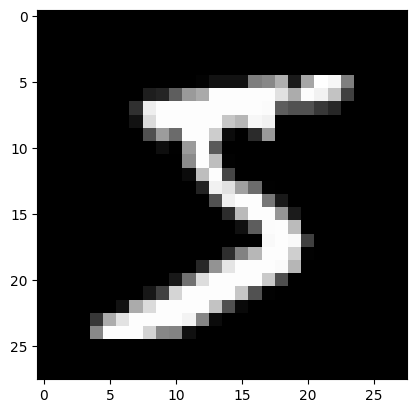

In [6]:
plt.imshow(train_data.data[0], cmap='gray')
plt.show()

In [7]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True) # mini batch 사이즈를 의미
test_loader = DataLoader(test_data, batch_size=32) # test는 섞을 필요 x

In [8]:
next(iter(train_loader))[0].shape # 32(갯수), 1(장수) : color 한가지, 28, 28

torch.Size([32, 1, 28, 28])

In [9]:
# 실무에서는 쓰기 어려운 형태(이미지는 복잡)
model = nn.Sequential(
    nn.Linear(784, 64), # 28*28
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 10) # 분류할 범주의 수를 미리 파악해서 설정(1 아님에 주의)
)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)

In [11]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()

custom_lr = 1e-3 # 0.003 or 0.001 주로 사용
criterion = nn.CrossEntropyLoss() # 딥러닝 + 분류모델 활용시 사용하는 손실 함수
optim = Adam(model.parameters(), lr = custom_lr) # 최적화 함수

epochs = 20
step = 0

for epoch in range(epochs):
    for data, label in train_loader: # [(image_data, y),...]
        
        optim.zero_grad()
        data = data.view(-1, 784) # model의 입력층이 784인지 확인 => [32, 784]
        #data = torch.reshape(data,(-1, 784))
        pred = model(data.to(device))
        loss = criterion(pred, label.to(device))
        writer.add_scalar('Loss/train', loss.item(), step) # x(step) / y(loss.item())
        step = step + 1
        loss.backward()
        optim.step()
        
    print(f'{epoch + 1} loss : {loss.item()}')    
    
    # 결과 웹 조회
    # tensorboard --logdir=.
    # uv run tensorboard --logdir runs
    # http://localhost:6006/?darkMode=true#timeseries
    

1 loss : 0.1451510787010193
2 loss : 0.08891759067773819
3 loss : 0.00567966140806675
4 loss : 0.13055311143398285
5 loss : 0.09179404377937317
6 loss : 0.01296965591609478
7 loss : 0.01641613431274891
8 loss : 0.0056990692391991615
9 loss : 0.0018382458947598934
10 loss : 0.0002815754269249737
11 loss : 0.004689801950007677
12 loss : 0.0008740303455851972
13 loss : 0.06327898800373077
14 loss : 0.0025601158849895
15 loss : 0.023868661373853683
16 loss : 0.005170307122170925
17 loss : 0.013783209025859833
18 loss : 0.0034096543677151203
19 loss : 0.04016628488898277
20 loss : 0.1295710653066635


In [12]:
model.eval() # 테스트 모드(추론)로 model을 전환(drop out등 값이 변화될 수 있는 것 제거)

with torch.no_grad(): # 자동 미분 종료
    
    total_corr = 0
    
    for images, labels in test_loader:
        images = images.view(-1, 784).to(device) # model과 input 일치화
        labels = labels.to(device)
        preds = model(images)
        _, pred = torch.max(preds.data, 1) # 적합도 배열, 1위 예측 배열
        
        total_corr = total_corr + (pred == labels).sum().item()

print(f'정확도 : {total_corr/len(test_data.targets)}')
print(preds.data.shape) # torch.Size([16, 10]) 32개씩 돌고 남은 16개

# 결과 확인 후 
# 1. Data 변경 2. Model 변경 3. Data 자체의 오류(ex: 9의 모양 확인)

정확도 : 0.9753
torch.Size([16, 10])
